# inverse design of a grating coupler with a vertical angle

In [1]:
import os

import meep.adjoint as mpa
import numpy as np
from autograd import grad
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import signal, special
import math
import meep as mp
import nlopt    # need install nlopt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
np.random.seed(0)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
mp.verbosity(0)

/tmp/ipykernel_2662/2675470795.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


1

**Basic setup**

In [2]:
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

##################### length parameter ################
input_wvg_length = 10
output_wvg_length = 5
# design_region
design_region_x = 15
design_region_y = 0.2
# period = 0.707  # period of grating coupler
# duty_cycle = 0.53  # duty cycle of grating coupler
# number_period = 20  # number of period of grating coupler
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)

####################### geometry ##########################
Substrate_geo = mp.Block(
    material=Si,
    center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
    size=mp.Vector3(sx, Substrate_thickness),
)
BOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml),
    size=mp.Vector3(sx, BOX_thickness),
)
TOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(
        y=-0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * TOX_thickness + dpml
    ),
    size=mp.Vector3(sx, TOX_thickness),
)
input_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        -0.5 * sx + 0.5 * input_wvg_length + dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(input_wvg_length, h),
)
output_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        0.5 * sx - 0.5 * output_wvg_length - dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(output_wvg_length, h),
)

geometry = [
    Substrate_geo,
    BOX_geo,
    TOX_geo,
    input_waveguide_geo,
    output_waveguide_geo,
]

####################### geometry ##########################

####################### design region ##########################
minimum_length = 0.05  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

design_region_resolution_x = int(resolution)
design_region_resolution_y = 5  # 200nm resolution
Nx = int(design_region_resolution_x * design_region_x)
Ny = int(design_region_resolution_y * design_region_y)
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_DEFAULT")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(
            -0.5 * sx + input_wvg_length + 0.5 * design_region_x + dpml,
            -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
            0,
        ),
        size=mp.Vector3(design_region_x, design_region_y),
    ),
)
geometry.append(
    mp.Block(
        center=design_region.center,
        size=design_region.size,
        material=design_variables,
    )
)
####################### design region ##########################

####################### Sources ##########################
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen
kpoint = mp.Vector3(1, 0, 0)

sources = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]
# set nomrlized source: amplitude is 1 -> flux is 1
sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)
####################### Sources ##########################


sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

## **目标函数**

1. 目标函数：J1：线性拟合误差最小化 J2：0-20 度功率 最大化
2. J3: 每一个角度的电场强度与目标电场强度的差值最小化 $ (-89, 0, 89) $ 
3. 将目标函数分为两个，(1)为其余角度最小的目标函数，(2)在0-25度范围内的与真实值的误差；增大第一个目标函数的权重

In [4]:
from scipy.optimize import fsolve

####################### monitor ##########################
# near_field_region
d_angle = 0.2
ff_distance = 1e6
ff_angle = 89
ff_number = int(2 / d_angle * ff_angle) + 1
ff_angles = np.linspace(-ff_angle, ff_angle, ff_number)
ff_points = [
    mp.Vector3(fx, 1e6, 0) for fx in np.tan(np.radians(ff_angles)) * ff_distance
]

start_angle = 0
stop_angle = 25

NearRegion = [
    mp.Near2FarRegion(
        center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
        size=mp.Vector3(sx - 2 * dpml, 0),
        weight=+1,
    )
]

# 归一化效率
efficiency = 0.76

ob_list = [mpa.Near2FarFields(sim, NearRegion, [ff_point]) for ff_point in ff_points]
final_intensity = np.load("norm_rel.npy") * efficiency


# 对比每一个角度下的电场强度与目标电场强度的差值
#! return scalar obj not vector
def J3(*FF):
    obj = 0
    points = []
    # 将FF中每一个的点的Ez值取出来存入points中
    # FF [list] FF[0][0, 0, 2] = point[0, 0, 2]
    # point.size -> [1, 1, 6] -> ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz']
    for point in FF:
        points.append(point[0, 0, 2])
    return npa.sum(npa.abs(npa.abs(points) ** 2 - final_intensity))


####################### monitor ##########################

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J3],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    decay_by=1e-5,
)

(891,)


891

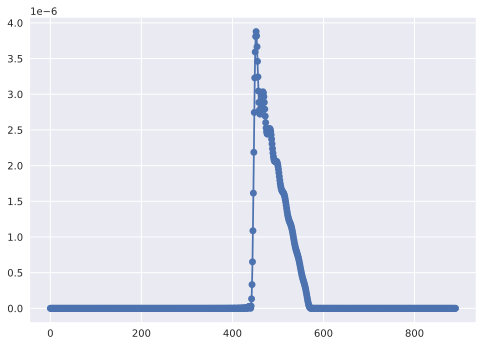

In [7]:
plt.plot(final_intensity, '-o')
print(final_intensity.shape)


**Confirm the optimization configuration.**

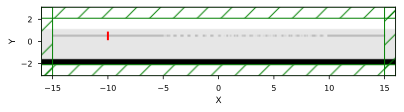

In [168]:
# define the initial design and confirm the optimization problem
number_para = Nx * Ny

# # 初始化grating coupler为周期性结构
# SiN_mesh = np.ones(
#     shape=[
#         18,
#     ]
# )
# etch_mesh = np.zeros(
#     shape=[
#         17,
#     ]
# )
# single_period = np.concatenate((SiN_mesh, etch_mesh), axis=0)
# init_para = np.tile(single_period, 22)

# 初始化granting coupler为上一次优化的结果
init_para = (np.abs(np.load("final_eps.npy")[0:number_para, 5]) - 1.44**2) / (
    1.96**2 - 1.44**2
)

init_para[init_para < 0] = 0
init_para[init_para > 1] = 1
opt.update_design([init_para[0:number_para]])
opt.plot2D(False)

**Define Nlopt**

In [169]:
f0, _ = opt([init_para[0:number_para]])

Starting forward run...
Starting adjoint run...
Calculating gradient...


In [170]:
f0

1.5675057084403524e-05

In [171]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([v])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = np.squeeze(dJ_du)

    evaluation_history.append(np.real(f0))

    # plt.figure()
    # ax = plt.gca()
    # opt.plot2D(
    #     False,
    #     ax=ax,
    #     plot_sources_flag=False,
    #     plot_monitors_flag=False,
    #     plot_boundaries_flag=False,
    # )
    # # circ = Circle((2, 2), minimum_length / 2)
    # # ax.add_patch(circ)
    # # ax.axis("off")
    # plt.show()

    print("Objective function: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)


algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
# x = np.random.random((n,)) * 0.5
x = init_para[0:number_para]

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))


# cur_beta = 4
# beta_scale = 2
# num_betas = 6
update_factor = 100
ftol = 1e-5

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(lb)
solver.set_upper_bounds(ub)
solver.set_min_objective(lambda a, g: f(a, g))
solver.set_maxeval(update_factor)
# solver.set_ftol_rel(ftol)
x[:] = solver.optimize(x)

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.5675057084403524e-05
Current iteration: 2
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.5675028083074438e-05
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.567473890038043e-05
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.5670578200180284e-05
Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.5642716536370643e-05
Current iteration: 6
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.5592598569408177e-05
Current iteration: 7
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.4875513913158494e-05
Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.814678619499652e-05
Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.3525236853470119e-05
Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.277304228017276e-05
Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.4772589599452825e-05
Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.254301156668381e-05
Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.2324505062485652e-05
Current iteration: 14
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.4760474065186491e-05
Current iteration: 15
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.2196691743342989e-05
Current iteration: 16
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.2093833554842687e-05
Current iteration: 17
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.3592062815200781e-05
Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.2110214989051092e-05
Current iteration: 19
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.2063996814768648e-05
Current iteration: 20
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.2015540512104697e-05
Current iteration: 21
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.365600278198999e-05
Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.2053767475002104e-05
Current iteration: 23
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.20181789424062e-05
Current iteration: 24
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.2009458124824507e-05
Current iteration: 25
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1998909279760375e-05
Current iteration: 26
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1948930738976756e-05
Current iteration: 27
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.492614163697645e-05
Current iteration: 28
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.2097929683744718e-05
Current iteration: 29
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.195611027922454e-05
Current iteration: 30
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.193112998820934e-05
Current iteration: 31
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.189965605136594e-05
Current iteration: 32
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.2227736004345304e-05
Current iteration: 33
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1924886617235487e-05
Current iteration: 34
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1886522892048953e-05
Current iteration: 35
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.188688491524185e-05
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
Objective function: 1.1885009115540392e-05
Current iteration: 37
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.188001221244138e-05
Current iteration: 38
Starting forward run...


Starting adjoint run...


Calculating gradient...
Objective function: 1.1877118747412296e-05
Current iteration: 39
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1874407751057448e-05
Current iteration: 40
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1849736855271489e-05
Current iteration: 41
Starting forward run...


Starting adjoint run...


Calculating gradient...
Objective function: 1.1994265972645018e-05
Current iteration: 42
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.1860918372133718e-05
Current iteration: 43
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.1845171297067906e-05
Current iteration: 44
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1828131669568328e-05
Current iteration: 45
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1944399521378809e-05
Current iteration: 46
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.1827881806795672e-05
Current iteration: 47
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1804050706637898e-05
Current iteration: 48
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.178675547079036e-05
Current iteration: 49
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1709367826510514e-05
Current iteration: 50
Starting forward run...


Starting adjoint run...


Calculating gradient...
Objective function: 1.9908474188870553e-05
Current iteration: 51
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.2036317625006057e-05
Current iteration: 52
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1723724060013431e-05
Current iteration: 53
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.1684237148468515e-05
Current iteration: 54
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1666378101544709e-05
Current iteration: 55
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1665888167170102e-05
Current iteration: 56
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1651088586414499e-05
Current iteration: 57
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.171737468463429e-05
Current iteration: 58
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1655076296976452e-05
Current iteration: 59
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1643900488934672e-05
Current iteration: 60
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1639875031855037e-05
Current iteration: 61
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1634427607579837e-05
Current iteration: 62
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.1644077519593725e-05
Current iteration: 63
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.1637532699625055e-05
Current iteration: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.1627449681426638e-05
Current iteration: 65
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1597560801895393e-05
Current iteration: 66
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.155561809151297e-05
Current iteration: 67
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.486180034084576e-05
Current iteration: 68
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1663755756908085e-05
Current iteration: 69
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1531943997566382e-05
Current iteration: 70
Starting forward run...


Starting adjoint run...


Calculating gradient...
Objective function: 1.1532091239349547e-05
Current iteration: 71
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1530240678658665e-05
Current iteration: 72
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1526436534582572e-05
Current iteration: 73
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.1525045105871084e-05
Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
Objective function: 1.1496897079548098e-05
Current iteration: 75
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1497857442296767e-05
Current iteration: 76
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.146848927585209e-05
Current iteration: 77
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.4383793618891535e-05
Current iteration: 78
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1669140898819321e-05
Current iteration: 79
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.1490235155506895e-05
Current iteration: 80
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1455871731324024e-05
Current iteration: 81
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1444167923171688e-05
Current iteration: 82
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1509279501840285e-05
Current iteration: 83
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1403887637729224e-05
Current iteration: 84
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1484122876112372e-05
Current iteration: 85
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.144097058013198e-05
Current iteration: 86
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.13645150818133e-05
Current iteration: 87
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.2439579481026509e-05
Current iteration: 88
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1473773723270647e-05
Current iteration: 89
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.1431453681761705e-05
Current iteration: 90
Starting forward run...
Starting adjoint run...
Calculating gradient...


Objective function: 1.1362844300443058e-05
Current iteration: 91
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1360946438181423e-05
Current iteration: 92
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.1352379962807171e-05
Current iteration: 93
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1429958661933015e-05
Current iteration: 94
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1431953544485399e-05
Current iteration: 95
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1352047538432643e-05
Current iteration: 96
Starting forward run...


Starting adjoint run...
Calculating gradient...
Objective function: 1.1431838416271979e-05
Current iteration: 97
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.135167096138404e-05
Current iteration: 98
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1431680454636906e-05
Current iteration: 99
Starting forward run...


Starting adjoint run...
Calculating gradient...


Objective function: 1.1351197863993167e-05
Current iteration: 100
Starting forward run...
Starting adjoint run...
Calculating gradient...
Objective function: 1.1431542701607455e-05


/tmp/ipykernel_13296/110120642.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


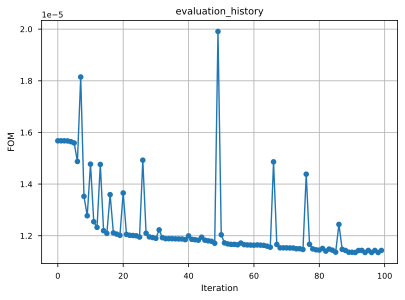

In [172]:
%config InlineBackend.figure_format = 'svg'

plt.figure()
plt.style.use("seaborn-paper")
plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.title('evaluation_history')
plt.show()


In [173]:
np.save("evaluation_history_4.npy", evaluation_history)

FloatProgress(value=0.0, description='0% done ', max=200.0)

<Axes: xlabel='X', ylabel='Y'>

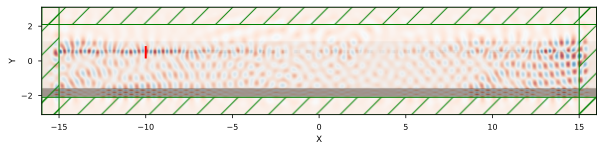

In [174]:
source_gs = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]

opt.sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=source_gs,
    geometry=geometry,
)

opt.sim.run(until=200)
plt.figure(figsize=(10, 20))
opt.sim.plot2D(fields=mp.Ez)

## Verify the optimization result

<Axes: xlabel='X', ylabel='Y'>

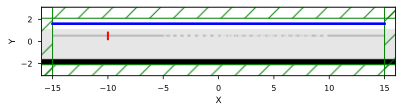

In [175]:
source_gs = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]
# set nomrlized source: amplitude is 1 -> flux is 1
source_gs[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)
sim_final = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=source_gs,
    geometry=geometry,
)

near_region = mp.FluxRegion(
    center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
    size=mp.Vector3(sx - 2 * dpml, 0),
)

near_field = sim_final.add_mode_monitor(
    fcen,
    0,
    1,
    near_region,
)

near_dft = sim_final.add_dft_fields(
    [mp.Ez], fcen, 0, 1, center=near_region.center, size=near_region.size
)

# near2far_field
n2f_field = sim_final.add_near2far(
    fcen,
    0,
    1,
    near_region,
)

sim_final.plot2D()

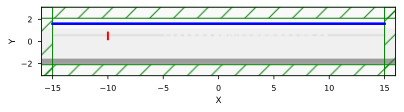

In [176]:
mpt = mp.Vector3(0.5 * sx - dpml - 1, output_waveguide_geo.center.y)

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim_final.run(
    mp.at_every(1, Animate),
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
)


In [177]:
filename = "inverse_design_angle_GS.mp4"
Animate.to_mp4(10, filename)

In [178]:
from IPython.display import Video

Video(filename)

(752, 12)


/tmp/ipykernel_13296/25150537.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")
/home/chen/miniconda3/envs/mp/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


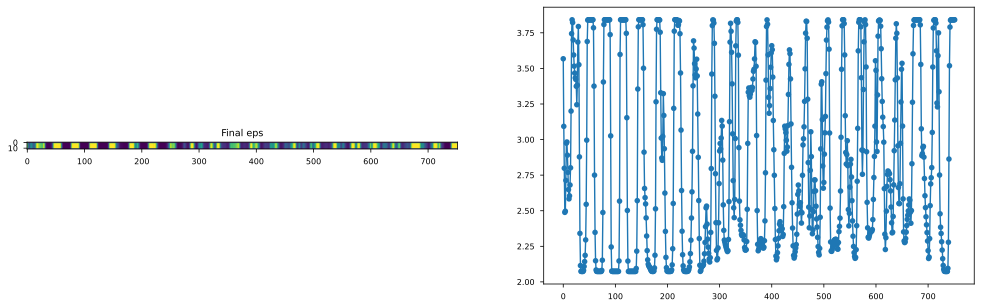

In [179]:
plt.style.use("seaborn-paper")
eps = sim_final.get_array(
    component=mp.Dielectric,
    frequency=fcen,
    center=mp.Vector3(
        -0.5 * sx + dpml + input_wvg_length + 0.5 * design_region_x,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
        0,
    ),
    size=mp.Vector3(design_region_x, h, 0),
)
np.save("final_eps.npy", eps)
print(eps.shape)
f1, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(np.rot90(np.abs(eps)))
ax[0].set_title("Final eps")
ax[1].plot(eps[:, 5], '-o')

In [180]:
sim_final.save_near2far('grating_coupler_near2far.h5', n2f_field)


In [181]:
n2f = []
for point in ff_points:
    ff = sim_final.get_farfield(n2f_field, point)
    n2f.append(ff)

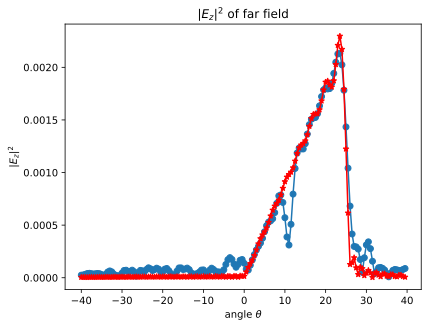

In [188]:
plt.style.use("default")
rel = []
for ff in n2f:
    rel.append(np.abs(ff[2]) ** 2)

figure, ax = plt.subplots()
angle_minlim = np.where(ff_angles == -40)[0][0]
angle_maxlim = np.where(ff_angles == 40)[0][0]
plt.plot(
    ff_angles[angle_minlim:angle_maxlim], np.sqrt(rel[angle_minlim:angle_maxlim]), "-o"
)
plt.title(r"$ |{E_z}|^2 $ of far field")
ax.set_xlabel(r"angle $ \theta $")
ax.set_ylabel(r"$ |{E_z}|^2 $")
plt.plot(
    ff_angles[angle_minlim:angle_maxlim],
    np.sqrt(final_intensity[angle_minlim:angle_maxlim]),
    "-r*",
)

In [183]:
# 计算总的power

ff_angles = np.linspace(-ff_angle, ff_angle, ff_number)
ff_points = [
    mp.Vector3(fx, 1e6, 0) for fx in np.tan(np.radians(ff_angles)) * ff_distance
]
ob_list = [sim_final.get_farfield(n2f_field, ff_point) for ff_point in ff_points]
n2f_angle_Ez = [Ez[2] for Ez in ob_list]

d_length = []
for angle in ff_angles:
    length = ff_distance / np.cos(np.radians(angle))
    d_length.append(np.radians(d_angle) * length)

energy = 0
for ii in range(0, ff_number, 1):
    energy = energy + d_length[ii] * (np.abs(n2f_angle_Ez[ii]) ** 2)

print(f"The power of near_field is {energy}")

The power of near_field is 0.7467535733208894


In [194]:
# 获得不同角度范围内的误差值
vf_obj_1 = 0
vf_obj_2 = 0
vf_obj_3 = 0

for angle in range(0, np.where(ff_angles == 0)[0][0] + 1, 1):
    vf_obj_1 += np.abs(rel[angle] - final_intensity[angle])
for angle in range(
    np.where(ff_angles == 0)[0][0], np.where(ff_angles == 25)[0][0] + 1, 1
):
    vf_obj_2 += np.abs(rel[angle] - final_intensity[angle])
for angle in range(np.where(ff_angles == 25)[0][0], ff_number, 1):
    vf_obj_3 += np.abs(rel[angle] - final_intensity[angle])
print(f"负角度：{vf_obj_1}")
print(f"0-25角度：{vf_obj_2}")
print(f"大角度：{vf_obj_3}")
print(vf_obj_1 + vf_obj_2 + vf_obj_3)

负角度：9.755924820616285e-07
0-25角度：8.393635051585695e-06
大角度：2.6372225638582287e-06
1.2006450097505551e-05


In [185]:
a = np.where(ff_angles == 0)
print(a[0][0])

178


## Visialization

设置光源为ContinueSource，其余与之前的设置保持一致

FloatProgress(value=0.0, description='0% done ', max=250.0)

<Axes: xlabel='X', ylabel='Y'>

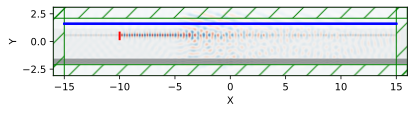

In [186]:
source_cw = [
    mp.EigenModeSource(
        mp.ContinuousSource(frequency=fcen),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]

sim_cw = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=source_cw,
    geometry=geometry,
)

near_region_cw = mp.FluxRegion(
    center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
    size=mp.Vector3(sx - 2 * dpml, 0),
)

near_field_cw = sim_cw.add_mode_monitor(
    fcen,
    0,
    1,
    near_region,
)

near_dft_cw = sim_cw.add_dft_fields(
    [mp.Ez], fcen, 0, 1, center=near_region.center, size=near_region.size
)

# near2far_field
n2f_field_cw = sim_cw.add_near2far(
    fcen,
    0,
    1,
    near_region,
)

# sim_cw.plot2D()
sim_cw.run(until=250)
plt.figure()
sim_cw.plot2D(fields=mp.Ez)

In [187]:
near_field_cw_data = sim_cw.get_flux_data(near_field_cw)
